In [1]:
# End-End training and testing of the new pytorch-based VGG16-deeplabv3 architecture

In [2]:
# https://stackoverflow.com/questions/37893755/tensorflow-set-cuda-visible-devices-within-jupyter
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# https://stackoverflow.com/questions/56008683/could-not-create-cudnn-handle-cudnn-status-internal-error
import tensorflow as tf
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.95)
config = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [3]:
import importlib

import wasserstein_utils
import data_utils
import losses
import networks
import deeplabv3 as dlv3
import utils

In [4]:
import time
import numpy as np

import data_utils
import losses

from IPython import display

In [5]:
import umap

In [23]:
backbone = 'vgg16'
dataset = "GTA5"

# H x W x C
img_shape = (512,1024,3)

# 19 classes + void
num_classes = 20

batch_size=4

do_training = True

epochs=100000
epoch_step=250

num_projections=100

source_data_dir = './processed-data/1024x512/19_classes/' + dataset + '/train/'
cityscapes_data_dir = './processed-data/1024x512/19_classes/CITYSCAPES/train/'
cityscapes_val_dir = './processed-data/1024x512/19_classes/CITYSCAPES/val/'

fn_w_dlv3 = "weights/" + dataset + "/" + backbone + "_deeplabv3.h5"
fn_w_cls = "weights/" + dataset + "/" + backbone + "_deeplabv3_classifier.h5"

fn_w_adapted_dlv3 = "weights/" + dataset + "/" + backbone +"_deeplabv3_adapted.h5"
fn_w_adapted_cls = "weights/" + dataset + "/" + backbone + "_deeplabv3_classifier_adapted.h5"

In [7]:
importlib.reload(losses)

deeplabv3 = dlv3.deeplabv3(activation=None, \
                           backbone=backbone, \
                           num_classes=num_classes)

X = deeplabv3.input
Y = tf.keras.layers.Input(shape=(img_shape[0], img_shape[1], num_classes,), dtype='float32', name='label_input')

C_in = tf.keras.layers.Input(shape=deeplabv3.layers[-1].output_shape[1:], dtype='float32', name='classifier_input')
classifier = tf.keras.Model(C_in, networks.classifier_layers(C_in, num_classes = num_classes, activation='softmax'))

# A combined model, giving the output of classifier(deeplabv3(X))
combined = tf.keras.Model(X, classifier(deeplabv3(X)))
combined.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False))

# A model outputting hxwx1 labels for each image. Also useful to verify the
# mIoU with Keras' built-in function. Will however also consider the 'ignore' class. 
combined_ = tf.keras.Model(X, tf.cast(tf.keras.backend.argmax(combined(X), axis=-1), 'float32'))
combined_.compile(metrics=[tf.keras.metrics.MeanIoU(num_classes=num_classes)])

# Set up training
opt = tf.keras.optimizers.Adam(lr=1e-4, epsilon=1e-8, decay=1e-6)
# opt = tf.keras.optimizers.SGD(lr=1e-4, momentum=.9)

loss_function = losses.weighted_ce_loss(num_classes, 0)
wce_loss = loss_function(Y, classifier(deeplabv3(X)), from_logits=False)

# https://stackoverflow.com/questions/55434653/batch-normalization-doesnt-have-gradient-in-tensorflow-2-0
params = deeplabv3.trainable_weights + classifier.trainable_weights

updates = opt.get_updates(wce_loss, params)

train = tf.keras.backend.function(inputs=[X,Y], outputs=[wce_loss], updates=updates)

In [8]:
deeplabv3.load_weights(fn_w_dlv3)
classifier.load_weights(fn_w_cls)

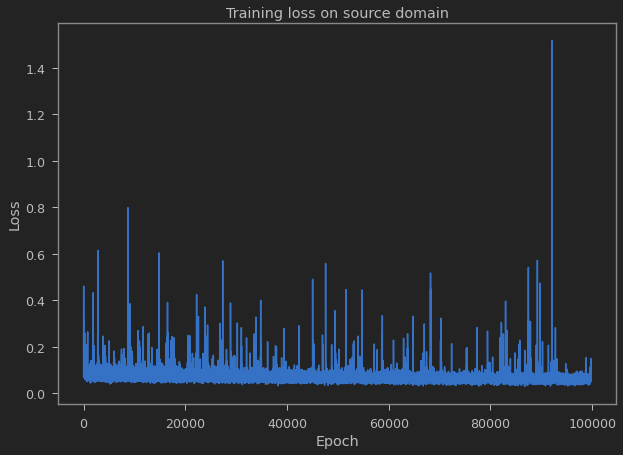

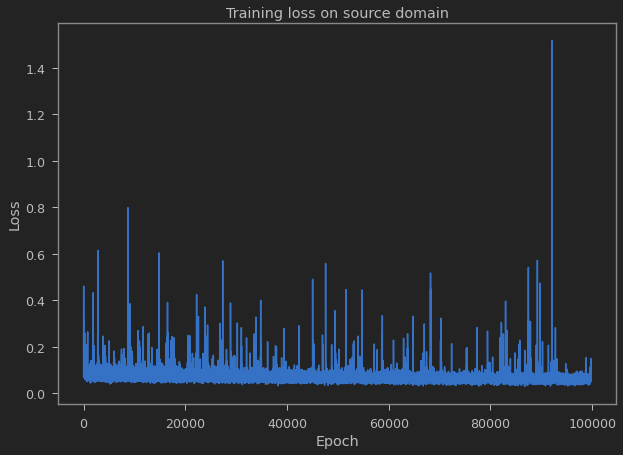

In [9]:
importlib.reload(data_utils)

# Training on source domain
if do_training == True:
    try:
        deeplabv3.load_weights(fn_w_dlv3)
        classifier.load_weights(fn_w_cls)

        print("Successfully loaded model. Continuing training.")
    except:
        print("Could not load previous model weights. Is a new model present?")
        
    start_time = time.time()

    fig,ax = plt.subplots(1,figsize=(10,7))

    loss_history = []

    for itr in range(epochs):
        source_train_data, source_train_labels = utils.sample_batch(source_data_dir, batch_size=batch_size, seed=itr)
        source_train_labels = tf.keras.utils.to_categorical(source_train_labels, num_classes=num_classes)

        loss_history.append(train(inputs=[source_train_data, source_train_labels ]))

        if np.isnan(np.sum(loss_history[-1])):
            print('ERROR. ENCOUNTERED NAN')
            break

        if itr%epoch_step == 0:
            if itr != 0:
                ax.clear()
                ax.plot(np.asarray(loss_history))

            ax.set_title("Training loss on source domain")
            ax.set_xlabel("Epoch")
            ax.set_ylabel("Loss")

            display.clear_output(wait=True)
            display.display(plt.gcf())
            time.sleep(1e-3)
            
        if itr % (epochs // 10) == 0 or itr == epochs - 1:
            deeplabv3.save_weights(fn_w_dlv3)
            classifier.save_weights(fn_w_cls)

    training_time = time.time() - start_time
else:
    deeplabv3.load_weights(fn_w_dlv3)
    classifier.load_weights(fn_w_cls)
    print("Loaded model weights")

In [12]:
import utils
importlib.reload(utils)

start_time = time.time()

source_cat_iou,source_miou = utils.compute_miou(source_data_dir, combined_, data_utils.label_ids_19, 0)

for k in source_cat_iou:
    print(k, source_cat_iou[k])
print(source_miou)

print('Computed ' + dataset + ' mIoU in', time.time() - start_time)

# road 0.8559070065772992
# sidewalk 0.9043721610536399
# building 0.8381948427759653
# wall 0.632677142340526
# fence 0.699526703820766
# pole 0.6073661307913504
# traffic light 0.7258756809296298
# traffic sign 0.6789546854786402
# vegetation 0.8526590005209183
# terrain 0.7779495588027171
# sky 0.9530645387149239
# person 0.7316948194592244
# rider 0.809945935261575
# car 0.5922120101790109
# truck 0.9211600020912953
# bus 0.9270433021188236
# train 0.8659149467023691
# motorcycle 0.6754852581619956
# bicycle 0.5876167577346231
# 0.7704010780797522
# Computed GTA5 mIoU in 1953.6462309360504

road 0.8559070065772992
sidewalk 0.9043721610536399
building 0.8381948427759653
wall 0.632677142340526
fence 0.699526703820766
pole 0.6073661307913504
traffic light 0.7258756809296298
traffic sign 0.6789546854786402
vegetation 0.8526590005209183
terrain 0.7779495588027171
sky 0.9530645387149239
person 0.7316948194592244
rider 0.809945935261575
car 0.5922120101790109
truck 0.9211600020912953
bus 0.9270433021188236
train 0.8659149467023691
motorcycle 0.6754852581619956
bicycle 0.5876167577346231
0.7704010780797522
Computed GTA5 mIoU in 1953.6462309360504


In [13]:
start_time = time.time()

cit_cat_iou,cit_miou = utils.compute_miou(cityscapes_data_dir, combined_, data_utils.label_ids_19, 0)

for k in cit_cat_iou:
    print(k, cit_cat_iou[k])
print(cit_miou)

print('Computed CITYSCAPES mIoU in', time.time() - start_time)

# road 0.4538541445555259
# sidewalk 0.17761519682584992
# building 0.5960010633542256
# wall 0.11064090337021892
# fence 0.08225737548235189
# pole 0.11701661235497808
# traffic light 0.2131517695419058
# traffic sign 0.085832471689785
# vegetation 0.7016830692115976
# terrain 0.05272756739697445
# sky 0.4267235195286716
# person 0.30570697364634025
# rider 0.03181916445284627
# car 0.4930313336164962
# truck 0.05910168795933546
# bus 0.052471835602942996
# train 0.003952731749887269
# motorcycle 0.07819570698033228
# bicycle 0.0073530220468457285
# 0.2131124289140585
# Computed CITYSCAPES mIoU in 249.57955932617188

road 0.4538541445555259
sidewalk 0.17761519682584992
building 0.5960010633542256
wall 0.11064090337021892
fence 0.08225737548235189
pole 0.11701661235497808
traffic light 0.2131517695419058
traffic sign 0.085832471689785
vegetation 0.7016830692115976
terrain 0.05272756739697445
sky 0.4267235195286716
person 0.30570697364634025
rider 0.03181916445284627
car 0.4930313336164962
truck 0.05910168795933546
bus 0.052471835602942996
train 0.003952731749887269
motorcycle 0.07819570698033228
bicycle 0.0073530220468457285
0.2131124289140585
Computed CITYSCAPES mIoU in 249.57955932617188


In [14]:
importlib.reload(utils)

start_time = time.time()
means, _, ct = utils.learn_gaussians(source_data_dir, deeplabv3, combined, batch_size, data_utils.label_ids_19)
print("computed means in", time.time() - start_time)

start_time = time.time()
means, covs, ct = utils.learn_gaussians(source_data_dir, deeplabv3, combined, batch_size, data_utils.label_ids_19, \
                                  initial_means=means)
print("finished training gaussians in", time.time() - start_time)

np.save("./extras/means_1024x512_" + backbone + "deeplabv3_" + dataset + ".npy", means)
np.save("./extras/covs_1024x512_" + backbone + "deeplabv3_" + dataset + ".npy", covs)

computed means in 6121.388354301453
finished training gaussians in 7654.087720870972


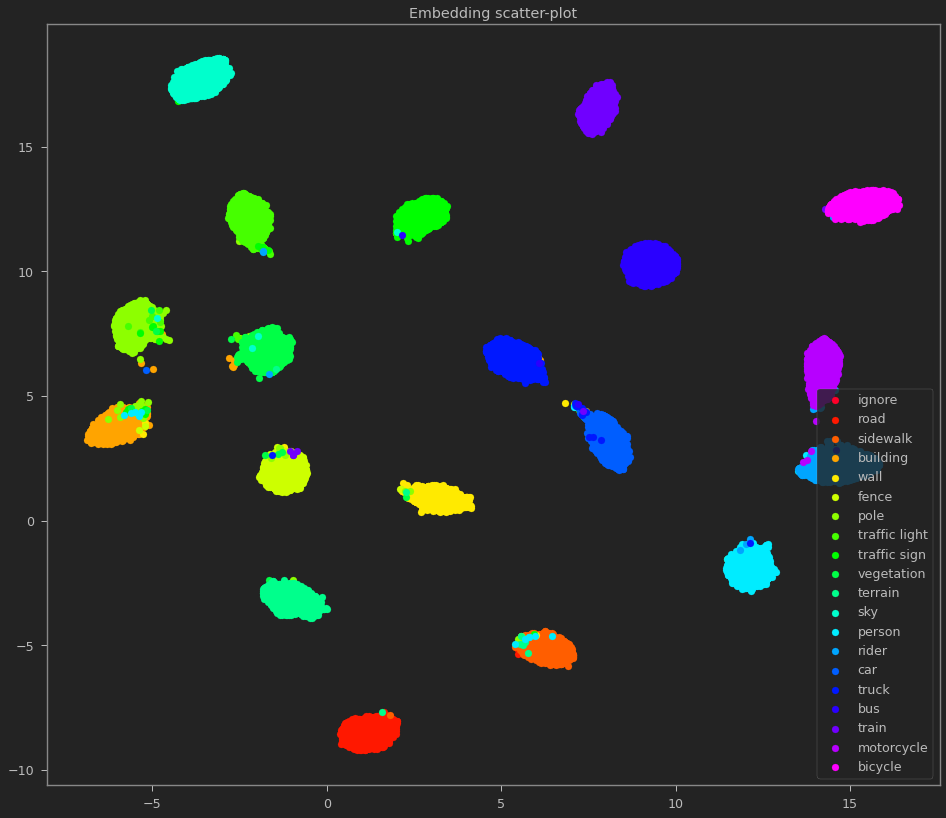

35.16640329360962


In [15]:
# Generate data from the gmm model and plot it

start_time = time.time()

n_samples = np.ones(num_classes, dtype=int)
n_samples[0] = 0
n_samples *= 2000

xx, yy = utils.sample_from_gaussians(means, covs, n_samples=n_samples)

NUM_COLORS = num_classes

reducer = umap.UMAP()

umap_embedding = reducer.fit_transform(xx)

plt.figure(figsize=(16,14))
cm = plt.get_cmap('gist_rainbow')

shift = 1 / len(data_utils.label_ids_19.keys())
idx = 0
for label in data_utils.label_ids_19:
    ind = yy == data_utils.label_ids_19[label]
    
    plt.scatter(umap_embedding[:,0][ind], umap_embedding[:,1][ind], label=label, \
                color=cm(1.*idx/NUM_COLORS))
    idx += 1

plt.title("Embedding scatter-plot")
plt.legend()
    
plt.show()

print(time.time() - start_time)

In [16]:
importlib.reload(wasserstein_utils)

Z_s = tf.keras.layers.Input(shape=(img_shape[0], img_shape[1], num_classes,) )
Y_s = tf.keras.backend.placeholder(shape=(None, img_shape[0], img_shape[1], num_classes), dtype='float32') #labels of input images oneHot
lambda2 = 5e-1

loss_function = losses.weighted_ce_loss(num_classes, 0)
wce_loss = loss_function(Y_s, classifier(Z_s), from_logits=False)

# Wasserstein matcing loss
theta = tf.keras.backend.placeholder(shape = (num_projections, num_classes), dtype='float32')
matching_loss = wasserstein_utils.sWasserstein_hd(deeplabv3(X), Z_s, theta, nclass=num_classes, Cp=None, Cq=None,)

# Overall loss is a weighted combination of the two losses
total_loss = wce_loss + lambda2*matching_loss

params = deeplabv3.trainable_weights + classifier.trainable_weights

# Optimizer and training setup
opt = tf.keras.optimizers.Adam(lr=1e-4, epsilon=1e-6, decay=1e-6)

updates = opt.get_updates(total_loss, params)
train = tf.keras.backend.function(inputs=[X,Z_s,Y_s,theta], outputs=[total_loss, wce_loss, matching_loss], updates=updates)

/home/serban/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [17]:
loss = []
target_miou = []

deeplabv3.load_weights(fn_w_dlv3)
classifier.load_weights(fn_w_cls)

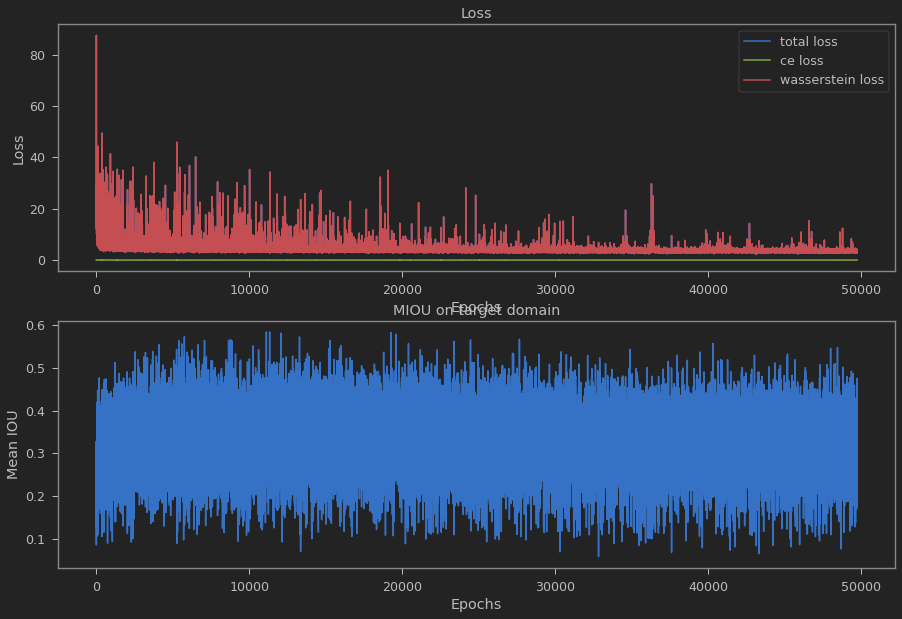

In [18]:
fig,ax=plt.subplots(2,figsize=(15,10))

batch_size = 1

thres = .99
epochs2 = 50000
epochstep = 250

for itr in range(epochs2):
    target_train_data, target_train_labels = utils.sample_batch(cityscapes_data_dir, batch_size=batch_size, seed=itr)

    # make sure the #samples from gaussians match the distribution of the labels
    n_samples = np.zeros(num_classes, dtype=int)
    cls, ns = np.unique(target_train_labels, return_counts=True)
    for i in range(len(cls)):
        if cls[i] == 0:
            continue
        n_samples[cls[i]] = ns[i]

    if np.sum(n_samples) % np.prod(img_shape) != 0:
        remaining = np.prod(img_shape[:-1]) - np.sum(n_samples) % np.prod(img_shape[:-1])

        aux = np.copy(n_samples) / np.sum(n_samples)
        aux *= remaining
        aux = np.floor(aux).astype('int')
        
        n_samples += aux

        # in case there are extra samples left, dump them on the highest represented class
        n_samples[np.argmax(n_samples)] += remaining - np.sum(aux)


    Yembed,Yembedlabels = utils.sample_from_gaussians(means, covs, n_samples = n_samples)
    Yembed = Yembed.reshape(-1, img_shape[0], img_shape[1], num_classes)
    Yembedlabels = Yembedlabels.reshape(-1, img_shape[0], img_shape[1])

    Yembedlabels = tf.keras.utils.to_categorical(Yembedlabels, num_classes=num_classes)

    theta_instance = tf.keras.backend.variable(wasserstein_utils.generateTheta(num_projections,num_classes))
    loss.append(train(inputs=[target_train_data, Yembed, Yembedlabels, theta_instance]))
    target_miou.append(combined_.evaluate(target_train_data, target_train_labels, verbose=False)[-1] * 20/19)
    
    if itr%epochstep==0:
        # Debug info. First, the mIoU. Second, the categorical CE loss (ignoring class weights and containing) 
        # the ignore class
        if itr != 0:
            ax[0].clear()
            
            ll = np.asarray(loss)
            ax[0].plot(ll[:,0], label='total loss')
            ax[0].plot(ll[:,1], label='ce loss')
            ax[0].plot(ll[:,2] * lambda2, label='wasserstein loss')
            ax[0].legend()
            
        ax[0].set_title("Loss")
        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("Loss")
        
        if itr != 0:
            ax[1].clear()
            ax[1].plot(np.asarray(target_miou))
        
        ax[1].set_title("MIOU on target domain")
        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("Mean IOU")
        
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        time.sleep(1e-3) 

In [19]:
import utils
importlib.reload(utils)

start_time = time.time()

source_cat_iou,source_miou = utils.compute_miou(source_data_dir, combined_, data_utils.label_ids_19, 0)

for k in source_cat_iou:
    print(k, source_cat_iou[k])
print(source_miou)

print('Computed ' + dataset + ' mIoU in', time.time() - start_time)

# road 0.6675523660118785
# sidewalk 0.28336359271439726
# building 0.6076388775470897
# wall 0.2672064026700072
# fence 0.17232300484931942
# pole 0.2735294951039704
# traffic light 0.32147051090247314
# traffic sign 0.07400171986539407
# vegetation 0.5965591779805058
# terrain 0.2889806932148324
# sky 0.8603173835723591
# person 0.3489449704700763
# rider 0.17189785226832072
# car 0.5761907340114261
# truck 0.2955718142857747
# bus 0.14318027819603177
# train 0.033001835642511974
# motorcycle 0.12385339561083183
# bicycle 0.025308995240981697
# 0.3226785842188517
# Computed GTA5 mIoU in 1957.6215891838074

road 0.6675523660118785
sidewalk 0.28336359271439726
building 0.6076388775470897
wall 0.2672064026700072
fence 0.17232300484931942
pole 0.2735294951039704
traffic light 0.32147051090247314
traffic sign 0.07400171986539407
vegetation 0.5965591779805058
terrain 0.2889806932148324
sky 0.8603173835723591
person 0.3489449704700763
rider 0.17189785226832072
car 0.5761907340114261
truck 0.2955718142857747
bus 0.14318027819603177
train 0.033001835642511974
motorcycle 0.12385339561083183
bicycle 0.025308995240981697
0.3226785842188517
Computed GTA5 mIoU in 1957.6215891838074


In [20]:
start_time = time.time()

cit_cat_iou,cit_miou = utils.compute_miou(cityscapes_data_dir, combined_, data_utils.label_ids_19, 0)

for k in cit_cat_iou:
    print(k, cit_cat_iou[k])
print(cit_miou)

print('Computed CITYSCAPES mIoU in', time.time() - start_time)

# road 0.7883116582422506
# sidewalk 0.6215464735885322
# building 0.751691007583865
# wall 0.3993120030432491
# fence 0.39173486089325144
# pole 0.302509334397975
# traffic light 0.3019573318279201
# traffic sign 0.38603017233885695
# vegetation 0.7792104073113252
# terrain 0.484321694588526
# sky 0.8323752669785053
# person 0.5206867614087272
# rider 0.2377222662760571
# car 0.8020324193022697
# truck 0.4754062370048565
# bus 0.593789975462107
# train 0.5966522990567177
# motorcycle 0.3119814031424603
# bicycle 0.47793033593638945
# 0.5292211530728338
# Computed CITYSCAPES mIoU in 232.43373942375183

road 0.7883116582422506
sidewalk 0.6215464735885322
building 0.751691007583865
wall 0.3993120030432491
fence 0.39173486089325144
pole 0.302509334397975
traffic light 0.3019573318279201
traffic sign 0.38603017233885695
vegetation 0.7792104073113252
terrain 0.484321694588526
sky 0.8323752669785053
person 0.5206867614087272
rider 0.2377222662760571
car 0.8020324193022697
truck 0.4754062370048565
bus 0.593789975462107
train 0.5966522990567177
motorcycle 0.3119814031424603
bicycle 0.47793033593638945
0.5292211530728338
Computed CITYSCAPES mIoU in 232.43373942375183


In [25]:
start_time = time.time()

cit_cat_iou,cit_miou = utils.compute_miou(cityscapes_val_dir, combined_, data_utils.label_ids_19, 0)

for k in cit_cat_iou:
    print(k, cit_cat_iou[k])
print(cit_miou)

print('Computed CITYSCAPES mIoU in', time.time() - start_time)

# road 0.7544163600114073
# sidewalk 0.5308953550336675
# building 0.717284542680233
# wall 0.23788752577432637
# fence 0.23876931970965581
# pole 0.30541033061844014
# traffic light 0.26957407403015937
# traffic sign 0.376477515173791
# vegetation 0.7753905145446299
# terrain 0.34884060225349456
# sky 0.7869146824909259
# person 0.4745299170266906
# rider 0.1876271570458875
# car 0.7709355490558467
# truck 0.22249057345069
# bus 0.44033013386788367
# train 0.2018302023064041
# motorcycle 0.14355169668014212
# bicycle 0.48504701470377987
# 0.43516858244516077
# Computed CITYSCAPES mIoU in 41.712018966674805

road 0.7544163600114073
sidewalk 0.5308953550336675
building 0.717284542680233
wall 0.23788752577432637
fence 0.23876931970965581
pole 0.30541033061844014
traffic light 0.26957407403015937
traffic sign 0.376477515173791
vegetation 0.7753905145446299
terrain 0.34884060225349456
sky 0.7869146824909259
person 0.4745299170266906
rider 0.1876271570458875
car 0.7709355490558467
truck 0.22249057345069
bus 0.44033013386788367
train 0.2018302023064041
motorcycle 0.14355169668014212
bicycle 0.48504701470377987
0.43516858244516077
Computed CITYSCAPES mIoU in 39.261150598526


In [24]:
deeplabv3.save_weights(fn_w_adapted_dlv3)
classifier.save_weights(fn_w_adapted_cls)